In [203]:
from qiskit import *

In [204]:
bit_size = 3

k = 6 # strike price
n = 3 # asset price

k_string = format(k,f'0{bit_size}b')
n_string = format(n,f'0{bit_size}b')

#if k>n: # set k_string and n_string to same length bitstring
#    n_string = n_string.zfill(len(k_string))
#else: 
#    k_string = k_string.zfill(len(n_string))


def twos_complement(k_string):
    # twos-complement
    if '1' not in k_string:
        return k_string
    power_two = 2**len(k_string) # next highest power of two
    complement = power_two-int(k_string,2)
    return format(int(complement),f'0{len(k_string)}b')

k_string = twos_complement(k_string)
k_string,n_string

('010', '110')

In [205]:
inputs = QuantumRegister(bit_size,name='inputs')
ancillae = QuantumRegister(bit_size,name='ancillae')
output = QuantumRegister(1,name='output')
circ = QuantumCircuit(inputs,ancillae,output,ClassicalRegister(1))

for i in range(len(n_string)): # initialise the inputs to n_string
    if n_string[i]=='1':
        circ.x(inputs[i])

In [206]:
def ccOR(circ,a,b,ancilla): #controlled-controlled-OR gate
    circ.barrier()
    circ.x(a)
    circ.x(b)
    circ.x(ancilla)

    circ.ccx(a,b,ancilla)

    circ.x(a)
    circ.x(b)
    circ.barrier()
    return circ

In [207]:
def comparison(circ,a,b):
    if a == 0:# and b=='1': # there is no 'a-1' ancilla for a=0, so only a single CNOT is needed
        circ.cx(inputs[0],ancillae[0])
        return circ

    if b=='1':
        circ.barrier()
        circ.ccx(inputs[a],ancillae[a-1],ancillae[a]) # can only carry if a-1 and a are 1
    else:
        circ = ccOR(circ,inputs[a],ancillae[a-1],ancillae[a]) # can carry if either a-1 or a are 1
    return circ

In [208]:
for i in range(len(k_string)):
    circ.barrier()
    circ = comparison(circ,i,k_string[i]) # loop through each digit in the bitstring, comparing each one

circ.barrier()
circ.cx(ancillae[-1],output[0]) # copy onto output
circ.barrier()
circ.measure(output[0],0)

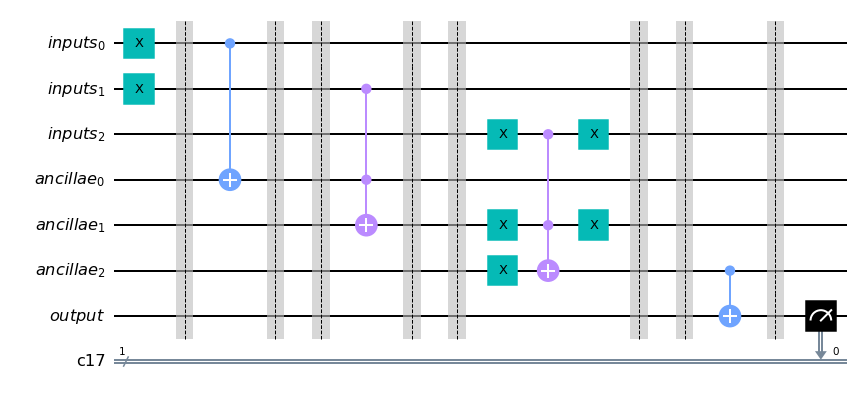

In [209]:
circ.draw(output='mpl')

In [210]:
def simulate(circ):
    
    job = execute(circ,backend=Aer.get_backend('aer_simulator'),shots=1,memory=True)
    return job.result().get_memory()

In [211]:
ans = simulate(circ)
ans

['1']

In [212]:
# test against supposed result
if (n>k) != (bool(int(ans[0]))):
    print(f'Error: n={n} and k={k} produced an output of {ans}.')

Error: n=3 and k=6 produced an output of ['1'].
